# continuous Fine-tune (在第一個session訓練，於之後的模型微調)

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import os
from sklearn.metrics import r2_score

from dataPreprocess import read_dataset
from model_tf import simpleDecodeModel

In [2]:
folderPath = './data'
fileList = sorted([i for i in os.listdir(folderPath) if i.endswith('.pkl.zip')])

In [3]:
n_epoch = 100

In [4]:
def retrain(train_x, train_y):
    model = simpleDecodeModel()
    model.compile(loss='mse', optimizer='adam', run_eagerly=True)
    
    train_x = sourceDataset['m1'][:5000]
    train_y = sourceDataset['movement'][:5000]
    model.fit(x=train_x, y=train_y, batch_size=256, epochs=n_epoch, verbose=1, shuffle=True)

    return model

In [5]:
def fintune(model, train_x, train_y):   
    train_x = targetDataset['m1'][:5000]
    train_y = targetDataset['movement'][:5000]

    model.fit(x=train_x, y=train_y, batch_size=256, epochs=n_epoch, verbose=1, shuffle=True)
    
    return model


In [6]:
def test(model, test_x, test_y):
    pred = model.predict(test_x)

    r2 = [r2_score(y_pred=pred[:, i], y_true=test_y[:, i]) for i in range(pred.shape[-1])]

    return r2

In [7]:
results = []

In [8]:
for sourceSessionIndex in range(1):
    targetSessionIndex = sourceSessionIndex + 1    
    
    sourceSession = fileList[sourceSessionIndex]
    sourceDataset = read_dataset(os.path.join(folderPath, sourceSession), ['velocity_x', 'velocity_y'])

    targetSession = fileList[targetSessionIndex]
    targetDataset = read_dataset(os.path.join(folderPath, targetSession), ['velocity_x', 'velocity_y'])

    model_retrain = retrain(train_x=sourceDataset['m1'][:5000, -5:, :], train_y=sourceDataset['movement'][:5000, :])

    # 使用前喔session的模型，在當前片段finetune
    model_single = simpleDecodeModel()
    model_single(tf.zeros([1, 5, 96])) # create weight

    model_single.set_weights(model_retrain.get_weights()) 
    model_single.compile(loss='mse', optimizer='adam', run_eagerly=True)

    model_single = fintune(model=model_single, \
        train_x=targetDataset['m1'][:5000, -5:, :], \
        train_y=targetDataset['movement'][:5000, :])
    
    # 使用第一個session的模型，不斷finetune至當前session
    if sourceSessionIndex == 0:
        model_continue = simpleDecodeModel()
        model_continue(tf.zeros([1, 5, 96])) # create weight

        model_continue.set_weights(model_retrain.get_weights()) 
        model_continue.compile(loss='mse', optimizer='adam', run_eagerly=True)
    
    model_continue = fintune(model=model_continue, \
        train_x=targetDataset['m1'][:5000, -5:, :], \
        train_y=targetDataset['movement'][:5000, :])

    
    ######################################################################
    # test
    test_x = targetDataset['m1'][5000:, -5:, :]
    test_y = targetDataset['movement'][5000:]

    r2_retrain = test(model_retrain, test_x, test_y)
    r2_finetune_single = test(model_single, test_x, test_y)
    r2_finetune_continue = test(model_continue, test_x, test_y)


    ######################################################################
    # save
    for axis_idx, axis in enumerate(['x', 'y']):
        results.append(['Finetune_Continuous', 'velocity', axis, r2_finetune_continue[axis_idx], \
            sourceSessionIndex, targetSessionIndex])
        results.append(['Finetune_Single', 'velocity', axis, r2_finetune_single[axis_idx], \
            sourceSessionIndex, targetSessionIndex])
        results.append(['Retrain', 'velocity', axis, r2_retrain[axis_idx], \
            sourceSessionIndex, targetSessionIndex])

20/20 [==============================] - 2s 115ms/step - loss: 36.6404


In [9]:
cols = ['method', 'movement', 'axis', 'r_square', 'sourceIndex', 'targetIndex']
results = pd.DataFrame(results, columns=cols)

In [10]:
results

,method,movement,axis,r_square,sourceIndex,targetIndex
0,Finetune_Continuous,velocity,x,0.503748,0,1
1,Finetune_Single,velocity,x,0.353961,0,1
2,Retrain,velocity,x,0.342568,0,1
3,Finetune_Continuous,velocity,y,0.329348,0,1
4,Finetune_Single,velocity,y,0.319739,0,1
5,Retrain,velocity,y,0.140752,0,1


# 畫圖

## 結果預覽

![](./figures/fffffinetune.png)

## 程式碼們

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid', font_scale=2)

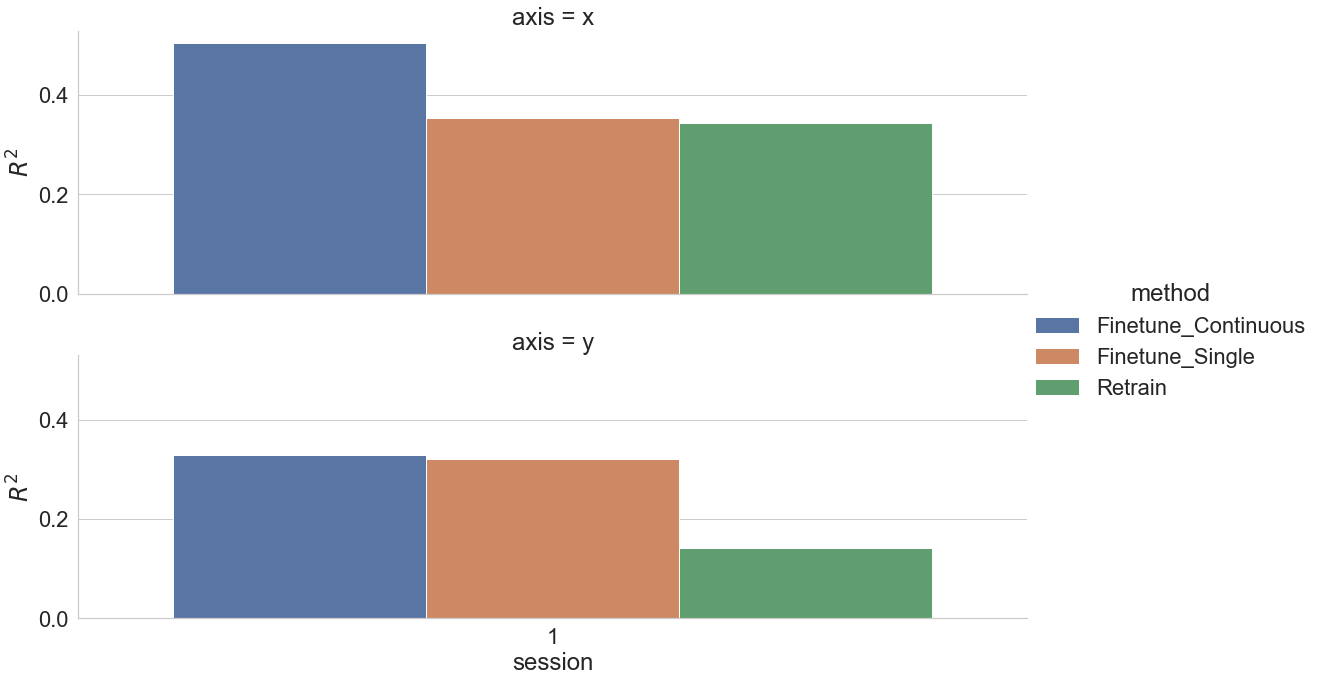

In [13]:
df = results

g = sns.catplot(kind='bar', data=df, x='targetIndex', y='r_square', hue='method', row='axis', aspect=3, height=5)
g.set(ylabel='$R^2$', xlabel='session')